# RNN

In [1]:
import numpy as np
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T,dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_State(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs
        
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh =0
        grads = [0, 0, 0]

        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

In [8]:
from common.time_layers import *
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [10]:
%matplotlib inline
from dataset import ptb
from common.optimizer import SGD
import matplotlib.pyplot as plt

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 150

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)

print('말뭉치 크기 : %d, 어휘 수 : %d' %(corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0 
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters) :
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기 : 1000, 어휘 수 : 418
| 에폭 1 | 퍼플렉서티 400.20
| 에폭 2 | 퍼플렉서티 284.68
| 에폭 3 | 퍼플렉서티 229.29
| 에폭 4 | 퍼플렉서티 216.63
| 에폭 5 | 퍼플렉서티 207.03
| 에폭 6 | 퍼플렉서티 203.23
| 에폭 7 | 퍼플렉서티 198.81
| 에폭 8 | 퍼플렉서티 196.09
| 에폭 9 | 퍼플렉서티 190.92
| 에폭 10 | 퍼플렉서티 191.65
| 에폭 11 | 퍼플렉서티 187.21
| 에폭 12 | 퍼플렉서티 190.88
| 에폭 13 | 퍼플렉서티 187.93
| 에폭 14 | 퍼플렉서티 188.89
| 에폭 15 | 퍼플렉서티 188.98
| 에폭 16 | 퍼플렉서티 185.77
| 에폭 17 | 퍼플렉서티 182.53
| 에폭 18 | 퍼플렉서티 181.81
| 에폭 19 | 퍼플렉서티 183.36
| 에폭 20 | 퍼플렉서티 182.89
| 에폭 21 | 퍼플렉서티 182.41
| 에폭 22 | 퍼플렉서티 177.25
| 에폭 23 | 퍼플렉서티 174.56
| 에폭 24 | 퍼플렉서티 175.68
| 에폭 25 | 퍼플렉서티 172.87
| 에폭 26 | 퍼플렉서티 172.70
| 에폭 27 | 퍼플렉서티 165.95
| 에폭 28 | 퍼플렉서티 164.60
| 에폭 29 | 퍼플렉서티 164.57
| 에폭 30 | 퍼플렉서티 156.17
| 에폭 31 | 퍼플렉서티 158.73
| 에폭 32 | 퍼플렉서티 151.88
| 에폭 33 | 퍼플렉서티 151.83
| 에폭 34 | 퍼플렉서티 147.61
| 에폭 35 | 퍼플렉서티 145.14
| 에폭 36 | 퍼플렉서티 139.25
| 에폭 37 | 퍼플렉서티 133.69
| 에폭 38 | 퍼플렉서티 131.24
| 에폭 39 | 퍼플렉서티 124.78
| 에폭 40 | 퍼플렉서티 120.73
| 에폭 41 | 퍼플렉서티 120.91
| 에폭 42 | 퍼플렉서티 113.30
| 에폭 43 | 퍼플렉서티 1

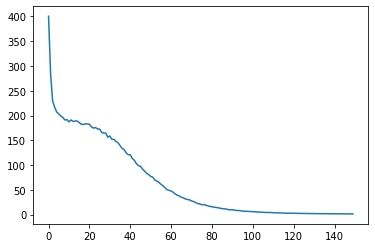

In [11]:
plt.plot(ppl_list)

In [12]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)
trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.45
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 400.65
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 299.87
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 231.28
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 214.52
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.18
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.65
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.50
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.27
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.39
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.32
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.61
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.60
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.41
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.92
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.15
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.91
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 182.95
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 178.73
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 182.65
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 177.70
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 177.